In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LinearRegression

In [ ]:
# Przygotowanie danych, część I.
chess_king_rook_vs_king = fetch_ucirepo(id=23) 
X = chess_king_rook_vs_king.data.features 
y = chess_king_rook_vs_king.data.targets 
print(chess_king_rook_vs_king.metadata) 
print(chess_king_rook_vs_king.variables) 
data = pd.concat([X, y], axis=1)
mask = [(data[i].dtype==np.object_)&(len(str(data[i].iloc[0]))==1) for i in data]
data.loc[:, mask] = data.loc[:, mask].apply(np.vectorize(lambda x: ord(x)-96))
MAP = {'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6,
       'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13,
       'fourteen': 14, 'fifteen': 15, 'sixteen': 16}
data['white-depth-of-win'] = (np.vectorize(lambda x: MAP[x]))(data['white-depth-of-win'])

{'uci_id': 23, 'name': 'Chess (King-Rook vs. King)', 'repository_url': 'https://archive.ics.uci.edu/dataset/23/chess+king+rook+vs+king', 'data_url': 'https://archive.ics.uci.edu/static/public/23/data.csv', 'abstract': 'Chess Endgame Database for White King and Rook against Black King (KRK).', 'area': 'Games', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 28056, 'num_features': 6, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['white-depth-of-win'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C57W2S', 'creators': ['Michael Bain', 'Arthur Hoff'], 'intro_paper': None, 'additional_info': {'summary': "An Inductive Logic Programming (ILP) or relational learning framework is assumed (Muggleton, 1992). The learning system is provided with examples of chess positions described only by the coordinates

In [ ]:
# Przygotowanie danych, część II. Funkcja pomocnicza.
plt.ioff()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
def create_chessboard(ax, data=None):
    im = None
    if(data is not None):
        im = ax.imshow(
            data,
            extent=[0, 8, 0, 8],
            origin="lower",
            cmap='Purples'
        )
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks([i + 0.5 for i in range(8)], minor=True)
    ax.set_yticks([i + 0.5 for i in range(8)], minor=True)
    ax.set_xticklabels([f"{chr(i+65)}" for i in range(8)], minor=True)
    ax.set_yticklabels([f"{i+1}" for i in range(8)], minor=True)
    ax.tick_params(which="major", labelbottom=False, labelleft=False)
    ax.grid(True)
    ax.set_aspect("equal")
    return im

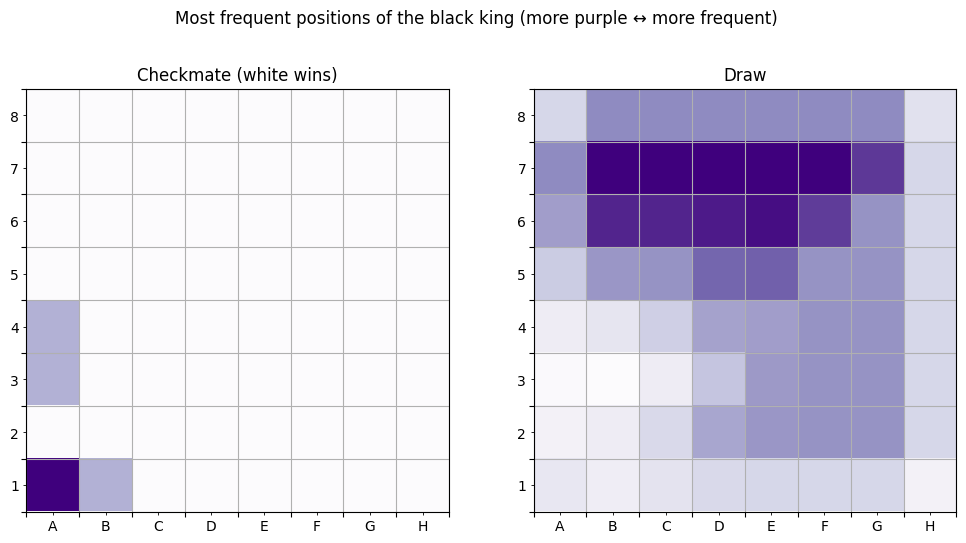

In [66]:
# Podpunkt a)
def transform(data, col):
    d = [[None]*8 for i in range(8)]
    for _, i in data.iterrows():
        d[int(i['x'])-1][int(i['y'])-1] = i[col]
    return d
dt = data.rename(columns={'black-king-file': 'x', 'black-king-rank': 'y'}).assign(mat=lambda df: np.where(df['white-depth-of-win']==0, 1, 0), pat=lambda df: np.where(df['white-depth-of-win']==-1, 1, 0)).loc[:,['x', 'y', 'mat', 'pat']].groupby(['x', 'y']).sum().reset_index()
im0 = create_chessboard(axes[0], transform(dt, 'mat'))
im1 = create_chessboard(axes[1], transform(dt, 'pat'))
fig.suptitle("Most frequent positions of the black king (more purple ↔ more frequent)")
axes[0].set_title("Checkmate (white wins)")
axes[1].set_title("Draw")
fig
# Jak widać na wizualizacjach, 
# w momencie przegranej czarny król zazwyczaj znajduje się w lewym dolnym rogu (A1) planszy,
# jedynie czasami w okolicznych kwadratach (B1, A3, A4).
# Dla remisu, najczęstsze pozycje znajdują się w 7 i 6 wierszu (B-G7, B-F6), 
# z wyłączeniem kolumny H. 

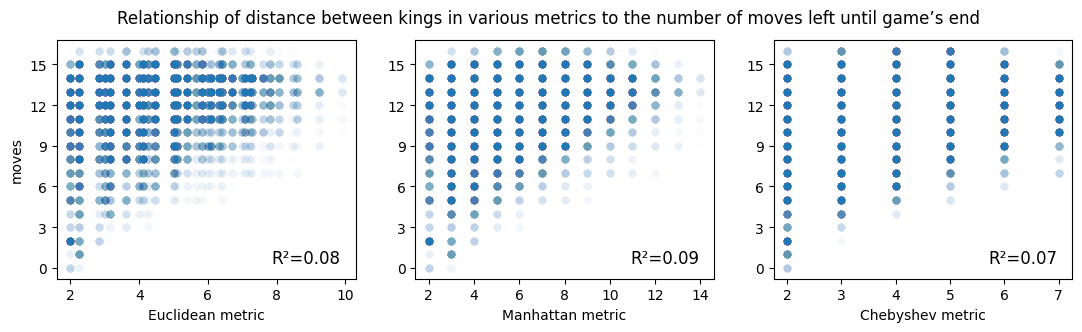

In [ ]:
# Podpunkt b)
def euclid(x1, y1, x2, y2):
    return ((x2-x1)**2 + (y2-y1)**2)**(1/2)
def manhattan(x1, y1, x2, y2):
    return np.abs(x1-x2)+np.abs(y1-y2)
def chebyshev(x1, y1, x2, y2):
    return np.max(np.vstack([np.abs(x1-x2), np.abs(y1-y2)]), axis=0)

dtm = data.rename(columns={'white-king-file': 'wx', 'white-king-rank': 'wy', 'black-king-file': 'bx',	'black-king-rank': 'by', 'white-depth-of-win': 'moves'}).loc[:,['wx', 'wy', 'bx', 'by', 'moves']].assign(euclidean=lambda df: euclid(df['wx'], df['wy'], df['bx'], df['by']), manhattan=lambda df: manhattan(df['wx'], df['wy'], df['bx'], df['by']), chebyshev=lambda df: chebyshev(df['wx'], df['wy'], df['bx'], df['by'])).loc[lambda df: df['moves']!=-1]
dtm1 = dtm.loc[:,['moves', 'euclidean', 'manhattan', 'chebyshev']]
fig1, axes1 = plt.subplots(1, 3, figsize=(13.1, 3.1))

lrs = {i: LinearRegression().fit(dtm1[i].to_numpy().reshape(-1, 1), dtm1['moves'].to_numpy().reshape(-1, 1)) for i in dtm1 if i != 'moves'}

fig1.suptitle('Relationship of distance between kings in various metrics to the number of moves left until game’s end')
alphas = [0.01, 0.01, 0.01]
for name, lr, i in zip(lrs.keys(), lrs.values(), range(3)):
    sns.scatterplot(dtm1, x=name, y='moves', alpha=alphas[i], ax=axes1[i])
    if(i):
        axes1[i].set_ylabel('')
    else:
        axes1[i].set_ylabel('Moves left until game’s end')
    axes1[i].set_yticks(range(0, 16, 3))
    axes1[i].set_xlabel(f"{name.capitalize()} metric")
    axes1[i].text(
        0.95, 0.05,
        f"R²={lr.score(dtm1[name].to_numpy().reshape(-1, 1), dtm1['moves'].to_numpy().reshape(-1, 1)):.2f}", 
        transform=axes1[i].transAxes, 
        ha='right',
        va='bottom',
        fontsize=12,
        color='black'
    )

# Duża wartość metryki przewiduje dużą liczbę ruchów pozostałą do zakończenia gry,
# jednak odwrotna zależność nie zachodzi dla żadnej z metryk.
# Najlepiej przewidują przebieg gry metryki euklidesowa oraz Manhattan,
# metryka Czebyszewa jest nieco gorsza.

<Axes: xlabel='Distance from chessboard edge', ylabel='Moves left until game’s end'>

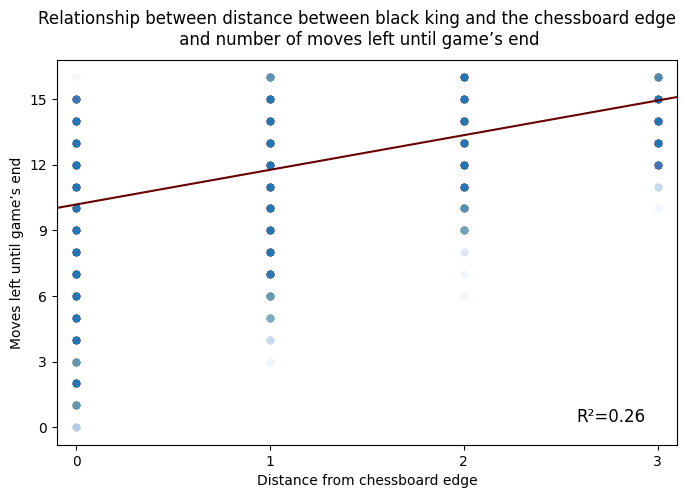

In [ ]:
# Podpunkt c) część I.
dtm2 = dtm.loc[:,['bx', 'by', 'moves', 'euclidean', 'manhattan', 'chebyshev']].assign(distance=lambda df: np.min(np.vstack([8-df['bx'], df['bx']-1, 8-df['by'], df['by']-1]), axis=0))
dtm2[dtm2.select_dtypes(include='object').columns] = (dtm2.select_dtypes(include='object').astype('float32'))
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 5))
sns.scatterplot(dtm2, x='distance', y='moves', alpha=0.01, ax=ax2)
ax2.set_yticks(range(0, 16, 3))
ax2.set_xlabel("Distance from chessboard edge")
ax2.set_xticks(range(4))
ax2.set_xlim(-0.1, 3.1)
lr1 = LinearRegression().fit(dtm2['distance'].to_numpy().reshape(-1, 1), dtm2['moves'].to_numpy().reshape(-1, 1))
ax2.text(
        0.95, 0.05,
        f"R²={lr1.score(dtm2['distance'].to_numpy().reshape(-1, 1), dtm2['moves'].to_numpy().reshape(-1, 1)):.2f}", 
        transform=ax2.transAxes,
        ha='right',
        va='bottom',
        fontsize=12,
        color='black'
    )
xv = np.linspace(-0.2, 3.2, 100)
ax2.set_ylabel('Moves left until game’s end')
fig2.suptitle('Relationship between distance between black king and the chessboard edge\n and number of moves left until game’s end')
sns.lineplot(x=xv, y=lr1.predict(xv.reshape(-1, 1))[:,0], ax=ax2, color="#600")
# Odległość czarnego króla od brzegu planszy lepiej przewiduje 
# szybkość zakończenia partii, niż wzajemna odległość dwóch królów od siebie.
# Może więc być przydatnym punktem danych.

Uzyskany wzór:
moves ≈ 6.43 + 0.58*[metryka Manhattan] + 2.03*[odległość czarnego króla od brzegu]


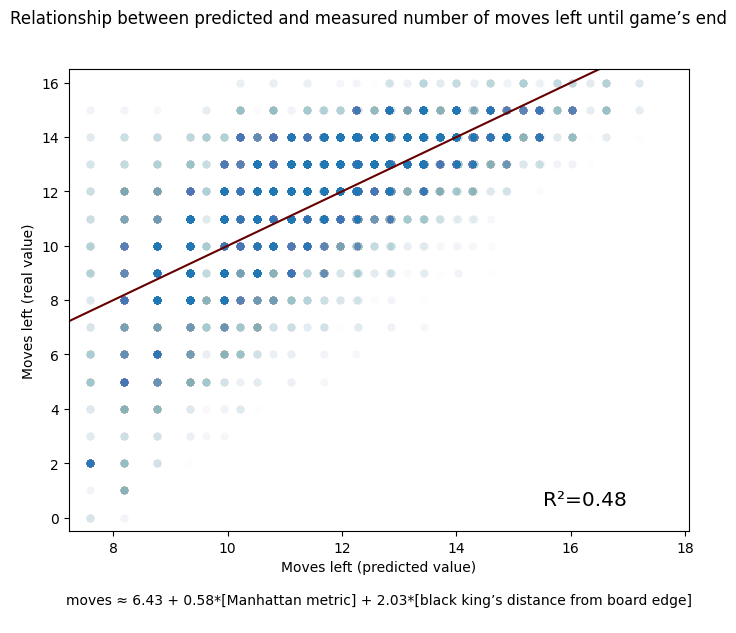

In [71]:
# Podpunkt c) część II.
# Uzupełnienie modelu analizy o dane na temat odległości obu królów od siebie.
# Najlepiej przewidywać wydaje się odległość w metryce Manhattan.

dtm2_proc = np.column_stack([np.ones(len(dtm2['distance'])), dtm2['distance'], dtm2['manhattan']])
beta = np.linalg.lstsq(dtm2_proc, dtm2['moves'], rcond=None)[0]
r2 = 1 - np.sum((dtm2['moves'] - dtm2_proc @ beta)**2) / np.sum((dtm2['moves'] - dtm2['moves'].mean())**2)
print(f"Uzyskany wzór:\nmoves ≈ {beta[0]:.2f} + {beta[2]:.2f}*[metryka Manhattan] + {beta[1]:.2f}*[odległość czarnego króla od brzegu]")
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 6))
dtm3 = dtm2.assign(prediction=lambda df: beta[0] + beta[2]*df['manhattan'] + beta[1]*df['distance']).loc[:,['moves', 'prediction']]
sns.scatterplot(
    dtm3,
    x='prediction',
    y='moves',
    ax=ax3,
    alpha=0.00678
)
ax3.text(
        0.85, 0.18,
        f"R²={r2:.2f}", 
        transform=ax2.transAxes,
        ha='right',
        va='bottom',
        fontsize=14.54,
        color='black'
    )
sns.lineplot(
    x=[0, 30],
    y=[0, 30],
    ax=ax3,
    color="#600"
)
ax3.set_ylim(-0.5, 16.5)
ax3.set_xlim(0.95*np.min(dtm3['prediction']), 1.05*np.max(dtm3['prediction']))
ax3.set_ylabel('Moves left (real value)')
ax3.set_xlabel(f'Moves left (predicted value)\n\nmoves ≈ {beta[0]:.2f} + {beta[2]:.2f}*[Manhattan metric] + {beta[1]:.2f}*[black king’s distance from board edge]\n')
fig3.suptitle('Relationship between predicted and measured number of moves left until game’s end')
fig3
# Wniosek.
# Przewidywanie liczby pozostałych ruchów może być wykonywane z pewną dokładnością
# za pomocą wzoru:
# [liczba ruchów] ≈ 6.43 + 0.58*[metryka Manhattan] + 2.03*[odległość czarnego króla od brzegu]
# Jest on znacznie dokładniejszy niż przewidywania na podstawie jednej wartości:
# zarówno dla metryk, jak i dla odległości od brzegu planszy.